In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
papers = pd.read_csv('paper_citation_lowlevel_cs.csv', index_col = 0)

/home/jz3502/.local/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Only use Level 3 topics

In [3]:
topics=pd.read_csv('./All data/advanced/FieldsOfStudy.txt',sep='\t', header = None,\
                   names = ['topic', 'Rank', 'NormalizedName', 'name', 'MainType', 'Level', 'PaperCount',\
                            'CitationCount', 'CreatedDate'])

In [4]:
level3 = topics[topics['Level'] == 3]['topic']

In [5]:
papers = papers[papers['FieldOfStudyId'].isin(level3)]

In [6]:
chunks=pd.read_csv('./All data/mag/PaperReferences.txt',chunksize=1000000,sep='\t', header = None,\
                   names = ['PaperId', 'PaperReferenceId'])

In [7]:
# Identify papers whose citations are cs papers
# *** Reference is paper referenced ***

paper_cs_citation = pd.DataFrame()

for chunk in chunks:
    paper_cs_citation= pd.concat([paper_cs_citation,\
                                  chunk[chunk['PaperReferenceId'].isin(papers['PaperId'])]])

In [8]:
paper_cs_citation.head()

,PaperId,PaperReferenceId
58,417,169276664
60,417,1493491511
66,417,1598226182
72,417,1994740826
73,417,2000735937


In [9]:
chunks = pd.read_csv('./All data/mag/Papers.txt',chunksize=1000000,sep = '\t', header = None,\
                       names = ['PaperId', 'Rank', 'Doi', 'DocType', 'PaperTitle', 'OriginalTitle', 'BookTitle', 'Year',\
                                'Date', 'Publisher', 'JournalId', 'ConferenceSeriesId', 'ConferenceInstanceId', 'Volume',\
                                'Issue', 'FirstPage', 'LastPage', 'ReferenceCount', 'CitationCount', 'EstimatedCitation',\
                                'OriginalVenue', 'FamilyId', 'CreatedDate'], low_memory = False)

In [10]:
# Find papers with cs paper id or citation paper id
# *** Reference is paper referenced ***

paper_year = pd.DataFrame()
paper_test = pd.DataFrame()

for chunk in chunks:
    paper_year= pd.concat([paper_year,chunk[(chunk['PaperId'].isin(paper_cs_citation['PaperId'])) |\
                                            (chunk['PaperId'].isin(paper_cs_citation['PaperReferenceId']))]])

In [11]:
paper_year = paper_year[['PaperId', 'Year']]

In [12]:
paper_cs_citation_year = paper_cs_citation.merge(paper_year, on = 'PaperId', how = 'left')
paper_cs_citation_year = paper_cs_citation_year.merge(paper_year, left_on = 'PaperReferenceId', right_on = 'PaperId',\
                                                          how = 'left')
paper_cs_citation_year.drop('PaperId_y', axis = 1, inplace = True)
paper_cs_citation_year.rename(columns = {'PaperId_x' : 'PaperId', 'Year_x' : 'Year', 'Year_y' : 'ReferenceYear'},\
                                inplace = True)

In [13]:
paper_cs_citation_year.head()

,PaperId,PaperReferenceId,Year,ReferenceYear
0,417,169276664,2002,1999
1,417,1493491511,2002,2001
2,417,1598226182,2002,1993
3,417,1994740826,2002,1990
4,417,2000735937,2002,1993


In [14]:
paper_cs_citation_year['Year'].fillna(0, inplace = True)
paper_cs_citation_year['Year'] = pd.to_numeric(paper_cs_citation_year['Year'].str[:4], errors = 'coerce')
paper_cs_citation_year['Year'] = paper_cs_citation_year['Year'].fillna(0)
paper_cs_citation_year['ReferenceYear'] = paper_cs_citation_year['ReferenceYear'].astype('int64')

In [15]:
# Identify citations within 2 years of publication of papers

paper_cs_citation_year_two = paper_cs_citation_year[np.abs((paper_cs_citation_year['Year'] -\
                                                     paper_cs_citation_year['ReferenceYear'])) <= 2]

# Count citation every year

paper_cs_citation_year_two = paper_cs_citation_year_two.groupby(['PaperReferenceId'], as_index = False)['PaperId'].count()
paper_cs_citation_year_two.rename(columns = {'PaperReferenceId' : 'PaperId', 'PaperId' : 'Count'}, inplace = True)

In [16]:
paper_cs_citation_year_two.head()

,PaperId,Count
0,1688,2
1,2468,4
2,2930,1
3,7383,1
4,8375,8


In [17]:
papers = papers[['PaperId', 'FieldOfStudyId', 'Year']].merge(paper_cs_citation_year_two, how = 'right', on = 'PaperId')

In [18]:
papers.dropna(inplace = True)

In [19]:
# Store train, validation, test data csv after splitting by year

for year in range(1990, 2018):
    paper = papers[(papers['Year'] == year) & (papers['Count'] >= 10)][['PaperId', 'FieldOfStudyId']]
    top_topics = paper.groupby('FieldOfStudyId', as_index = False)['PaperId'].count()\
                      .sort_values('PaperId', ascending = False).iloc[:500]
    
    paper = paper[paper['FieldOfStudyId'].isin(top_topics['FieldOfStudyId'])]

    paper_pivot = paper.pivot_table(index = ['PaperId'], columns = ['FieldOfStudyId'], aggfunc = [len], fill_value = 0)
    paper_pivot.columns = paper_pivot.columns.droplevel()
    paper_pivot.index.name = None
    paper_pivot.columns.name = None
    paper_pivot = paper_pivot.r eset_index()
    paper_count = paper_pivot.merge(papers[papers['Year'] == year][['PaperId', 'Count']], how = 'left',\
                                    left_on = 'index', right_on = 'PaperId')
    paper_count = paper_count.drop(['PaperId'], axis =1)
    paper_count.set_index('index', inplace = True)
    paper_count.index.name = None
    paper_count = paper_count.drop_duplicates()
    paper_count['Count'] = np.log(paper_count['Count'])
    

    paper_count.to_csv('./cs_fm_level3/paper_cs '+str(year)+'.csv')

## DEPRECATED

### Adjusted Citation = Citation / (2020-publication year)

In [20]:
# Restrict papers to be papers with more than 50 citation counts

# papers_citation = papers.groupby('PaperId', as_index = False)['ModifiedCitation'].mean()

In [21]:
# papers_citation = papers_citation[papers_citation['ModifiedCitation'] >= 5]

In [22]:
# papers = papers[papers['PaperId'].isin(papers_citation['PaperId'])]

In [23]:
# Restrict keywords to be keywords with more than 50 paper

# keywords_papercount = papers.groupby(['FieldOfStudyId', 'Year'], as_index = False)['PaperId'].count()

In [24]:
# keywords_paperavg = keywords_papercount.groupby('FieldOfStudyId', as_index = False)['PaperId'].mean()

In [25]:
# keywords_paperavg = keywords_paperavg[keywords_paperavg['PaperId'] >= 25]

In [26]:
# papers = papers[papers['FieldOfStudyId'].isin(keywords_paperavg['FieldOfStudyId'])]

In [27]:
# # Uniuqe papers

# papers['PaperId'].nunique()

In [28]:
# # Uniuqe keywords

# papers['FieldOfStudyId'].nunique()

In [29]:
# papers.head()

In [30]:
# # Check data size every year

# papers.groupby('Year', as_index = False).count()

In [31]:
# # Store train, validation, test data csv after splitting by year

# for year in range(1990, 2018):
#     paper = papers[papers['Year'] == year][['PaperId', 'FieldOfStudyId']]

#     paper_pivot = paper.pivot_table(index = ['PaperId'], columns = ['FieldOfStudyId'], aggfunc = [len], fill_value = 0)
#     paper_pivot.columns = paper_pivot.columns.droplevel()
#     paper_pivot.index.name = None
#     paper_pivot.columns.name = None
#     paper_pivot = paper_pivot.reset_index()
#     paper_count = paper_pivot.merge(papers[papers['Year'] == year][['PaperId', 'ModifiedCitation']], how = 'left',\
#                                     left_on = 'index', right_on = 'PaperId')
#     paper_count = paper_count.drop(['PaperId'], axis =1)
#     paper_count.set_index('index', inplace = True)
#     paper_count.index.name = None
    
#     train, val, test = np.split(paper_count.sample(frac=1), [int(.7*len(paper_count)), int(.9*len(paper_count))])
#     train.to_csv('./cs_fm_csv/paper_cs_train '+str(year)+'.csv')
#     val.to_csv('./cs_fm_csv/paper_cs_val '+str(year)+'.csv')
#     test.to_csv('./cs_fm_csv/paper_cs_test '+str(year)+'.csv')

### Factorization Machine

In [32]:
# Downgrade tensorflow to 1.0+ to use tffm

In [33]:
import tensorflow as tf

/home/jz3502/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jz3502/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jz3502/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jz3502/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:474: 

In [34]:
import numpy as np
import time
from tqdm import tqdm
from tffm import TFFMRegressor
from sklearn.metrics import mean_squared_error as mse
from collections import defaultdict

In [35]:
def factorization_machine_regression(order, loss_list = [], weight_dict = {}):
    
    for year in range(1990, 2018):
        data = pd.read_csv('./cs_fm_level3/paper_cs '+str(year)+'.csv', index_col = 0)
        train, val, test = np.split(data.sample(frac=1), [int(.7*len(data)), int(.9*len(data))])
        
        # Train model
        val_loss = 10*8
        val_reg = 0
        for reg in [10**x for x in range(-3, 2)]:
            model = TFFMRegressor(
                order=order, 
                rank=10, 
                optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                n_epochs=50, 
                batch_size=1024,
                init_std=0.001,
                reg=reg,
                input_type='dense',
                seed=42
            )
            model.fit(train.drop('Count', axis =1).values, train['Count'].values, show_progress=False)
            predictions = model.predict(val.drop('Count', axis =1).values)
            cur_loss = mse(val['Count'].values, predictions)
            
            if cur_loss < val_loss:
                val_loss = cur_loss
                val_reg = reg
                
        # Test model        
        model = TFFMRegressor(
        order=order, 
        rank=10, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=50, 
        batch_size=1024,
        init_std=0.001,
        reg=val_reg,
        input_type='dense',
        seed=42
        )
        model.fit(train.drop('Count', axis =1).values, train['Count'].values, show_progress=False)
        predictions = model.predict(test.drop('Count', axis =1).values)
        test_loss = mse(test['Count'].values, predictions)
        loss_list.append(test_loss)
        
        # Return top weighted keywords
        if order == 1:
            weights = model.session.run(model.core.w[0])
            weights_sort = np.argsort(-weights.squeeze())[:10]
            keywords_sort = train.columns[weights_sort].tolist()
            weight_dict[year] = keywords_sort
            
        elif order == 2:
            weights = model.session.run(model.core.w[1])
            weights_dict = {}
            keywords_list = []
            for i in range(0, weights.shape[0] - 1):
                for j in range(i+1, weights.shape[0]):
                    weights_dict[(i,j)] = np.dot(weights[i],weights[j])
            weights_dict_sort = sorted(weights_dict.items(), key = lambda x : x[1], reverse = True)[:10]
            
            for k in weights_dict_sort:
                keywords = train.columns[list(k[0])].tolist()
                keywords_list.append(keywords)
            weight_dict[year] = keywords_list
            
        elif order == 3:
            weights = model.session.run(model.core.w[2])
            weights_dict = {}
            keywords_list = []
            for i in range(0, weights.shape[0] - 2):
                for j in range(i+1, weights.shape[0]-1):
                    for w in range(j+1, weights.shape[0]):
                        weights_dict[(i,j,w)] = (weights[i] * weights[j] * weights[w]).sum()
            weights_dict_sort = sorted(weights_dict.items(), key = lambda x : x[1], reverse = True)[:10]
            
            for k in weights_dict_sort:
                keywords = train.columns[list(k[0])].tolist()
                keywords_list.append(keywords)
            weight_dict[year] = keywords_list
            
    return loss_list, weight_dict

In [36]:
first_order_loss, first_order_topkeywords = factorization_machine_regression(1, loss_list = [], weight_dict = {})

In [37]:
second_order_loss, second_order_topkeywords = factorization_machine_regression(2, loss_list = [], weight_dict = {})

In [38]:
third_order_loss, third_order_topkeywords = factorization_machine_regression(3, loss_list = [], weight_dict = {})

In [39]:
# ten_order_loss, _ = factorization_machine_regression(10, loss_list = [], weight_dict = {})

In [40]:
first_order_loss

[7.329217542695627,
 7.635343236899077,
 7.142927622793624,
 6.995619775438744,
 6.815454879086248,
 6.782905515467367,
 6.764202970367962,
 6.84921130829306,
 6.702919754659925,
 6.188629659000971,
 6.137726243304541,
 5.7422543885787585,
 5.833976190798261,
 5.800054023572508,
 5.375106528297505,
 5.139578348529813,
 5.030671555562351,
 4.91320436105232,
 4.978061890983888,
 4.95925504864761,
 4.897025619788996,
 4.766285629295161,
 4.856412014341627,
 4.675786339226253,
 5.038051809833454,
 5.085442693346553,
 5.0611010597594905,
 4.807975191947399]

In [41]:
second_order_loss

[7.24272685545353,
 7.549574330868344,
 6.952121473822609,
 6.766962887583411,
 6.306685732098959,
 6.348823402809643,
 6.083369134370635,
 5.8764836870828345,
 5.823715745006705,
 5.29545565148424,
 5.343832941524901,
 4.659631990364784,
 4.811347241754527,
 4.8535510462059,
 4.575573903641282,
 4.380597186558914,
 4.382459630587851,
 4.158004551300317,
 4.325811684203379,
 4.341480702663074,
 4.155458564420076,
 4.226005553658929,
 4.484211522080308,
 4.194224947134886,
 4.352152395576866,
 4.492331128549747,
 4.550346113052316,
 4.5114746180038345]

In [42]:
third_order_loss

[7.242401587243248,
 7.549173732419953,
 6.950507888557508,
 6.7653788931312775,
 6.304310014254403,
 6.347005252191626,
 6.0822638472043815,
 5.875933690959893,
 5.825632257392602,
 5.298994864394866,
 5.351815023024713,
 4.662863162361282,
 4.826161166456008,
 4.863752111883172,
 4.587939335138623,
 4.382543174233071,
 4.391946344791632,
 4.1677849842449675,
 4.326060888871177,
 4.346590479765731,
 4.162293864912538,
 4.226438586304387,
 4.486855714626888,
 4.195657787027122,
 4.357771453158976,
 4.49894076795015,
 4.560707358015289,
 4.512426218741227]

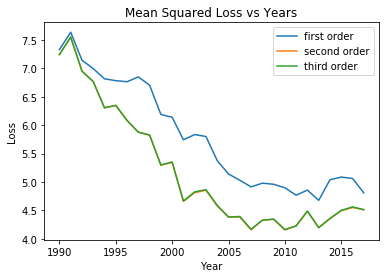

In [43]:
plt.plot(np.arange(28), first_order_loss, label = 'first order')
plt.plot(np.arange(28), second_order_loss, label = 'second order')
plt.plot(np.arange(28), third_order_loss, label = 'third order')
# plt.plot(np.arange(28), ten_order_loss, label = 'tenth order')
plt.legend()
plt.xticks(np.arange(0, 28, 5), np.arange(1990, 2018, 5))
plt.title('Mean Squared Loss vs Years')
plt.xlabel('Year')
plt.ylabel('Loss')

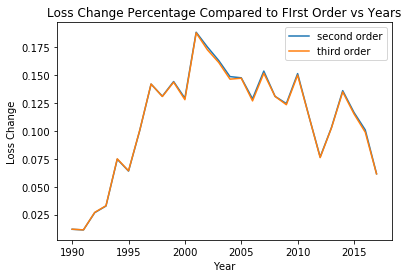

In [44]:
plt.plot(np.arange(28), (np.array(first_order_loss) - np.array(second_order_loss))/np.array(first_order_loss),\
         label = 'second order')
plt.plot(np.arange(28), (np.array(first_order_loss) - np.array(third_order_loss))/np.array(first_order_loss),\
         label = 'third order')
# plt.plot(np.arange(28), np.abs((np.array(ten_order_loss) - np.array(first_order_loss))/np.array(first_order_loss)),\
#          label = 'ten order')
plt.legend()
plt.xticks(np.arange(0, 28, 5), np.arange(1990, 2018, 5))
plt.title('Loss Change Percentage Compared to FIrst Order vs Years')
plt.xlabel('Year')
plt.ylabel('Loss Change')

In [45]:
# Return topic names of the indices

topics=pd.read_csv('./All data/advanced/FieldsOfStudy.txt',sep='\t', header = None,\
                   names = ['topic', 'Rank', 'NormalizedName', 'name', 'MainType', 'Level', 'PaperCount',\
                            'CitationCount', 'CreatedDate'])

In [46]:
import copy

first_results = copy.deepcopy(first_order_topkeywords)
second_results = copy.deepcopy(second_order_topkeywords)
third_results = copy.deepcopy(third_order_topkeywords)

In [47]:
for year in range(1990, 2018):
    for i, keyword in enumerate(first_results[year]):
        first_results[year][i] = topics[topics['topic'] == int(keyword)]['name'].item()

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  app.launch_new_instance()


In [48]:
for year in range(1990, 2018):
    for i, keyword in enumerate(second_results[year]):
        second_results[year][i][0] = topics[topics['topic'] == int(keyword[0])]['name'].item()
        second_results[year][i][1] = topics[topics['topic'] == int(keyword[1])]['name'].item()

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  app.launch_new_instance()
/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version


In [49]:
for year in range(1990, 2018):
    for i, keyword in enumerate(third_results[year]):
        third_results[year][i][0] = topics[topics['topic'] == int(keyword[0])]['name'].item()
        third_results[year][i][1] = topics[topics['topic'] == int(keyword[1])]['name'].item()
        third_results[year][i][2] = topics[topics['topic'] == int(keyword[2])]['name'].item()

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  app.launch_new_instance()
/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version


In [50]:
from pprint import pprint

### Note: Within each year, the keywords (combinations) are listsed in descending order w.r.t weights

In [51]:
pprint(first_results)

{1990: ['Boolean circuit',
        'Automated planning and scheduling',
        'Cognitive model',
        'Timer',
        'Prototype filter',
        'Hash table',
        'Distributed design patterns',
        'Natural language generation',
        'Personal area network',
        'Probabilistic argumentation'],
 1991: ['Principle of compositionality',
        'Method',
        'Lexical decision task',
        'QRS complex',
        'Garbage',
        'ENCODE',
        'Routing protocol',
        'Optimizing compiler',
        'Lexical choice',
        'Synchronizing'],
 1992: ['Workstation',
        'Software development',
        'Asynchronous Transfer Mode',
        'Digital electronics',
        'Graph theory',
        'Application software',
        'Systems architecture',
        'Fifth-generation programming language',
        'Spread spectrum',
        'Distributed memory'],
 1993: ['Dynamic priority scheduling',
        'Workstation',
        'Data compression',
        'Ti

In [52]:
pprint(second_results)

{1990: [['Distributed memory', 'Memory address'],
        ['Registered memory', 'Memory address'],
        ['Disk array controller', 'Disk controller'],
        ['Software development', 'ConceptBase'],
        ['Distributed memory', 'Registered memory'],
        ['Software system', 'ConceptBase'],
        ['Software system', 'Software development'],
        ['Inductive programming', 'Fifth-generation programming language'],
        ['Directory service', 'Atomicity'],
        ['Deterministic finite automaton', 'Atomicity']],
 1991: [['Digital electronics', 'Logic synthesis'],
        ['Mixed-signal integrated circuit', 'Logic synthesis'],
        ['Logic synthesis', 'Sequential logic'],
        ['Mixed-signal integrated circuit', 'Digital electronics'],
        ['Parallel programming model', 'Optimizing compiler'],
        ['Combinational logic', 'Logic synthesis'],
        ['Digital electronics', 'Sequential logic'],
        ['Mixed-signal integrated circuit', 'Sequential logic'],
    

In [53]:
pprint(third_results)

{1990: [['Automatic test pattern generation', 'Scan chain', 'Sequential logic'],
        ['Scan chain', 'Sequential logic', 'Ada'],
        ['Viterbi algorithm', 'Scan chain', 'Boolean expression'],
        ['Virtual circuit', 'Broadband networks', 'Leaky bucket'],
        ['Boundary scan', 'Leaky bucket', 'Debugging'],
        ['Broadband networks',
         'Reduced instruction set computing',
         'Sequential logic'],
        ['Parallel programming model',
         'Bulk synchronous parallel',
         'Analysis of parallel algorithms'],
        ['Automatic test pattern generation',
         'Software fault tolerance',
         'Bandwidth management'],
        ['Maximum a posteriori estimation',
         'Markov model',
         'Multilayer perceptron'],
        ['Bandwidth management', 'SIMD', 'Markov model']],
 1991: [['Packet switching',
         'Broadband networks',
         'Asynchronous Transfer Mode'],
        ['Processing delay', 'End-to-end delay', 'Transmission delay'